In [10]:
import numpy as np
import json
import os
import pandas as pd

import subprocess

from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
%config Completer.use_jedi = False

In [3]:
useless_cat_call = subprocess.run(["ls", "-lh"], stdout=subprocess.PIPE)
print(useless_cat_call.stdout)  # Hello from the other side

b'total 1088\ndrwxr-xr-x      9 sergmiller  staff   288B Nov  7 03:37 catboost_info\ndrwxr-xr-x  13446 sergmiller  staff   420K Nov  9 20:05 errorlogs\ndrwxr-xr-x    502 sergmiller  staff    16K Nov  7 04:57 features\ndrwxr-xr-x   8278 sergmiller  staff   259K Nov  9 12:15 features_iter\ndrwxr-xr-x    994 sergmiller  staff    31K Nov  8 01:01 features_v2\ndrwxr-xr-x    987 sergmiller  staff    31K Nov  8 03:08 features_v3\ndrwxr-xr-x   2119 sergmiller  staff    66K Nov  9 20:02 replays\n-rw-r--r--      1 sergmiller  staff   437K Nov  9 00:39 research-v1.ipynb\n-rw-r--r--      1 sergmiller  staff   102K Nov  9 20:04 rl-part.ipynb\ndrwxr-xr-x     45 sergmiller  staff   1.4K Nov  9 01:14 runs\ndrwxr-xr-x      5 sergmiller  staff   160B Nov  9 19:55 utils\n'


In [4]:
useless_cat_call.returncode

0

In [34]:
simple_bot = "../submissions/simple/main.py"
replays = "replays"

def run_game(left_bot=simple_bot, right_bot=simple_bot, seed=42, loglevel=2):
    replay_path = "replay.json"
    python_v = "python3.7"
    
    replay_path = os.path.join(replays, str(np.random.randint(1e9)) + ".json")
    
    size = np.random.choice([12,16,24,32], size=1)[0]
    
    res = subprocess.run([
        "lux-ai-2021",
        left_bot,
        right_bot,
#         "--statefulReplay",
        "--width={}".format(size),
        "--height={}".format(size),
        "--loglevel={}".format(loglevel),
        "--python={}".format(python_v),
        "--seed={}".format(seed),
        "--out={}".format(replay_path)], stdout=subprocess.PIPE)
    
    if loglevel > 0:
        print(res.stdout.decode())

    assert res.returncode == 0

    with open(replay_path, "r") as f:
        result = json.load(f)
    return result, res.stdout.decode()

In [35]:
import hashlib

def build_runnable_bot_with_flags(flags: dict, origin = simple_bot, base_path = '../submissions/simple/') -> str:
    lines = []
    with open(origin, "r") as f:
        for line in f:
            lines.append(line[:-1])
    text = '\n'.join(lines)
    f = json.dumps(flags)
    text = text.format(f)
    h = int(hashlib.sha256(f.encode('utf-8')).hexdigest(), 16) % (10 ** 18)
    path = base_path + "main_" + str(h) + ".py"
    with open(path, "w") as f:
        f.write(text)
    return path

In [96]:
path = build_runnable_bot_with_flags({"debug": True})

In [97]:
path

'../submissions/simple/main_{"debug": true}.py'

In [101]:
r = run_game(simple_bot, simple_bot, 42)


-=-=-=-=-=-=-=-=-=-=-=-| [INFO] match_XQGm5T3Z5jkg |-=-=-=-=-=-=-=-=-=-=-=-

[INFO] (match_XQGm5T3Z5jkg) - Design: lux_ai_2021 | Initializing match - ID: XQGm5T3Z5jkg, Name: match_XQGm5T3Z5jkg
[WARN] (match_XQGm5T3Z5jkg) - turn 15; Unit u_2 collided when trying to move w to (23, 29)
[WARN] (match_XQGm5T3Z5jkg) - turn 15; Unit u_4 collided when trying to move s to (23, 29)
[WARN] (match_XQGm5T3Z5jkg) - turn 21; Unit u_6 collided when trying to move w to (22, 29)
[WARN] (match_XQGm5T3Z5jkg) - turn 25; Unit u_9 collided when trying to move e to (24, 27)
[WARN] (match_XQGm5T3Z5jkg) - turn 26; Unit u_10 collided when trying to move n to (21, 28)
[WARN] (match_XQGm5T3Z5jkg) - turn 28; Unit u_4 collided when trying to move n to (23, 26)
[WARN] (match_XQGm5T3Z5jkg) - turn 28; Unit u_13 collided when trying to move w to (23, 27)
[WARN] (match_XQGm5T3Z5jkg) - turn 29; Unit u_5 collided when trying to move n to (8, 27)
[WARN] (match_XQGm5T3Z5jkg) - turn 29; Unit u_7 collided when trying to move 

In [36]:
from joblib import Parallel, delayed

In [37]:
def run_series(l, r, seed=42, n_runs=10, n_jobs=4):
    import tqdm
    assert n_runs % 2 == 0
    results = []
    
    with Parallel(n_jobs=n_jobs) as P:
        results = P(delayed(run_game)(l if t % 2 == 0 else r, r if t % 2 == 0 else l, seed + t, 0) for t in tqdm.tqdm(np.arange(n_runs), position=0))
    
    return results

In [38]:
def count_series(results: list):
    wins = []
    for i, r in enumerate(results):
        ranks = r[0]['results']['ranks']
        teams = r[0]['teamDetails']
        if ranks[0]['rank'] == 1 and ranks[1]['rank'] == 2:
            if ranks[0]["agentID"] == i % 2:
                wins.append(1)
            else:
                wins.append(0)
        else:
            wins.append(0.5)
    return wins

In [39]:
def calc_z_test(series: np.array):
    N = len(series)
    p = 0.5
    y = np.sum(series)
    z = (y - N * p) / (N * p * (1 - p)) ** 0.5
    
    from scipy.stats import norm
    def p_val(x):
        return 2 * min(norm.cdf(-x), norm.cdf(x))
    
    return y / N, z, p_val(z)

In [40]:
def build_bot_from_many(source) -> str:
    if isinstance(source, dict):
        s = build_runnable_bot_with_flags(source)
    else:
        assert isinstance(source, str)
        s = source
    return s

def compare_flags(flags_left, flags_right, n_games: int=10, seed: int=42):
    l = build_bot_from_many(flags_left)
    r = build_bot_from_many(flags_right)
    series = run_series(l, r, seed, n_games)
    counts = count_series(series)
    return calc_z_test(np.array(counts)), series[0][0]['results']

In [13]:
# compare_flags({"alfa": 0.9}, {"alfa": 0.0}, n_games=2)

In [58]:
compare_flags({"alfa": 0.9}, {"alfa": 0.0}, n_games=20)

100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


(0.475, -0.22360679774997896, 0.8230632737581215)

In [59]:
compare_flags({"alfa": 0.9}, {"alfa": 1.0}, n_games=20)

100%|██████████| 20/20 [00:56<00:00,  2.80s/it]


(0.5, 0.0, 1.0)

In [64]:
compare_flags({"alfa": 0.0}, {"alfa": 1.0}, n_games=20)

100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


(0.3, -1.7888543819998317, 0.07363827012030266)

In [72]:
compare_flags({"alfa": 0.0}, {"alfa": 1.0}, n_games=40)

100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


(0.35, -1.8973665961010275, 0.057779571123597245)

In [62]:
compare_flags({"norm_fuel_to_city_size": True}, {}, n_games=20)

100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


(0.425, -0.6708203932499369, 0.5023349543605021)

In [76]:
compare_flags({"go_resource_next_action_probs": [0.25, 0.75]}, {}, n_games=40)

100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


(0.675, 2.2135943621178655, 0.026856695507524397)

In [77]:
compare_flags({"go_resource_next_action_probs": [0.1, 0.9]}, {}, n_games=40)

100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


(0.65, 1.8973665961010275, 0.057779571123597245)

In [83]:
compare_flags({"go_resource_next_action_probs": [0.25, 0.75], "norm_probs_to_city_tiles": True}, {}, n_games=40)

100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


((0.575, 0.9486832980505138, 0.34278171114791145),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/34159252.json'})

In [85]:
zero_bot = "../submissions/zero_actions/main.py"
r = run_game(simple_bot, "/Users/sergmiller/Downloads/submission-5/main.py", 42)


-=-=-=-=-=-=-=-=-=-=-=-| [INFO] match_M2qKXLJ1wmsG |-=-=-=-=-=-=-=-=-=-=-=-

[INFO] (match_M2qKXLJ1wmsG) - Design: lux_ai_2021 | Initializing match - ID: M2qKXLJ1wmsG, Name: match_M2qKXLJ1wmsG
[WARN] (match_M2qKXLJ1wmsG) - turn 21; Unit u_4 collided when trying to move n to (2, 9)
[WARN] (match_M2qKXLJ1wmsG) - turn 26; Unit u_1 collided when trying to move n to (1, 9)
[WARN] (match_M2qKXLJ1wmsG) - turn 26; Unit u_6 collided when trying to move w to (1, 10)
[WARN] (match_M2qKXLJ1wmsG) - turn 27; Unit u_1 collided when trying to move w to (0, 10)
[WARN] (match_M2qKXLJ1wmsG) - turn 27; Unit u_6 collided when trying to move w to (1, 10)
[WARN] (match_M2qKXLJ1wmsG) - turn 27; Unit u_3 collided when trying to move n to (0, 10)
[WARN] (match_M2qKXLJ1wmsG) - turn 27; Unit u_7 collided when trying to move n to (0, 11)
[WARN] (match_M2qKXLJ1wmsG) - turn 35; Unit u_3 collided when trying to move n to (1, 10)
[WARN] (match_M2qKXLJ1wmsG) - turn 35; Unit u_6 collided when trying to move w to (1, 10

In [106]:
compare_flags({}, "/Users/sergmiller/Downloads/submission-5/main.py", n_games=40)

100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


((0.4625, -0.4743416490252569, 0.6352562959972483),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/419589201.json'})

In [111]:
compare_flags({"check_only_adjacent_city_points": True}, {}, n_games=40)

100%|██████████| 40/40 [00:56<00:00,  1.40s/it]


((0.325, -2.2135943621178655, 0.026856695507524397),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/951213014.json'})

In [118]:
compare_flags({"skip_mine_and_build_loop": True}, {}, n_games=2)

100%|██████████| 2/2 [00:00<00:00, 12264.05it/s]


((0.0, -1.414213562373095, 0.15729920705028516),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/312348333.json'})

In [113]:
compare_flags({"go_to_city_at_night": True}, {}, n_games=40)

100%|██████████| 40/40 [01:11<00:00,  1.78s/it]


((0.475, -0.31622776601683794, 0.7518296340458492),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/41791872.json'})

In [117]:
compare_flags({"skip_go_to_city_on_zero_dist": True, "go_to_city_at_night": True}, {}, n_games=80)

100%|██████████| 80/80 [01:44<00:00,  1.30s/it]


((0.45625, -0.7826237921249264, 0.4338480657664392),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/657084024.json'})

In [116]:
compare_flags({"skip_go_to_city_on_zero_dist": True, "go_to_city_at_night": True}, "/Users/sergmiller/Downloads/submission-5/main.py", n_games=40)

100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


((0.4375, -0.7905694150420948, 0.42919530044034926),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/295897956.json'})

In [125]:
compare_flags({"use_size_as_distance": True}, {}, n_games=40)

100%|██████████| 40/40 [00:42<00:00,  1.05s/it]


((0.3625, -1.7392527130926085, 0.081990321000383),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/39046897.json'})

In [126]:
compare_flags({"go_resource_next_action_probs": [0.25, 0.75]}, {}, n_games=40)

100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


((0.5875, 1.1067971810589328, 0.2683816272927607),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/175835218.json'})

In [129]:
compare_flags({"go_resource_next_action_probs": [0.1, 0.9]}, {}, n_games=40)

100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


((0.725, 2.846049894151541, 0.004426525857919832),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/640888564.json'})

In [130]:
compare_flags({"go_resource_next_action_probs": [0.1, 0.9]}, "/Users/sergmiller/Downloads/submission-5/main.py", n_games=40)

100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


((0.6625, 2.0554804791094465, 0.03983261924474144),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/412483474.json'})

In [131]:
compare_flags({"use_old_units_cargo_rules": False}, "/Users/sergmiller/Downloads/submission-5/main.py", n_games=40)

100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


((0.55, 0.6324555320336759, 0.5270892568655381),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/554223651.json'})

In [ ]:
compare_flags({"use_old_units_cargo_rules": False}, "/Users/sergmiller/Downloads/submission-5/main.py", n_games=40)

In [133]:
compare_flags({"use_old_units_cargo_rules": False, "go_resource_next_action_probs": [0.5, 0.5]}, {}, n_games=40)

100%|██████████| 40/40 [01:28<00:00,  2.22s/it]


((0.275, -2.846049894151541, 0.004426525857919832),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/870054567.json'})

In [127]:
compare_flags({"go_resource_next_action_probs": [0.05, 0.95]}, {}, n_games=40)

100%|██████████| 40/40 [01:12<00:00,  1.82s/it]


((0.7, 2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/53090520.json'})

In [128]:
compare_flags({"go_resource_next_action_probs": [0.0, 1.0]}, {}, n_games=40)

100%|██████████| 40/40 [01:30<00:00,  2.27s/it]


((0.7, 2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/507062604.json'})

In [134]:
compare_flags({"stop_mining_threshold": 99}, {}, n_games=40)

100%|██████████| 40/40 [01:16<00:00,  1.90s/it]


((0.6375, 1.7392527130926085, 0.081990321000383),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/182478039.json'})

In [135]:
compare_flags({"stop_mining_threshold": 50}, {}, n_games=40)

100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


((0.5625, 0.7905694150420948, 0.42919530044034926),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/846145215.json'})

In [137]:
compare_flags({"stop_mining_threshold": 79}, {}, n_games=40)

100%|██████████| 40/40 [01:10<00:00,  1.76s/it]


((0.675, 2.2135943621178655, 0.026856695507524397),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/752854654.json'})

In [138]:
compare_flags({"stop_mining_threshold": 79}, "/Users/sergmiller/Downloads/submission-5/main.py", n_games=40)

100%|██████████| 40/40 [01:05<00:00,  1.64s/it]


((0.675, 2.2135943621178655, 0.026856695507524397),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/947433138.json'})

In [139]:
compare_flags({"stop_mining_threshold": 79, "use_old_units_cargo_rules": False}, "/Users/sergmiller/Downloads/submission-5/main.py", n_games=40)

100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


((0.6625, 2.0554804791094465, 0.03983261924474144),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/583013079.json'})

In [140]:
compare_flags({"stop_mining_threshold": 79, "use_old_units_cargo_rules": False}, {}, n_games=40)

100%|██████████| 40/40 [01:12<00:00,  1.81s/it]


((0.5625, 0.7905694150420948, 0.42919530044034926),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/792768760.json'})

In [141]:
compare_flags({"stop_mining_threshold": 79, "random_pillage_prob": 0.1}, {}, n_games=40) #"random_pillage_prob"

100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


((0.5, 0.0, 1.0),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/433330989.json'})

In [151]:
compare_flags({"stop_mining_threshold": 79}, {"stop_mining_threshold": 0}, n_games=40)

100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


((0.725, 2.846049894151541, 0.004426525857919832),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/357037306.json'})

In [150]:
compare_flags({"stop_mining_threshold": 79, "fill_future_positions_each_turn": True}, {"stop_mining_threshold": 0}, n_games=40)

100%|██████████| 40/40 [01:12<00:00,  1.81s/it]


((0.525, 0.31622776601683794, 0.7518296340458492),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/332667360.json'})

In [152]:
# remove_future_position_if_go_in_city
compare_flags({"fill_future_positions_each_turn": True}, {}, n_games=80)

100%|██████████| 80/80 [01:47<00:00,  1.34s/it]


((0.54375, 0.7826237921249264, 0.4338480657664392),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/845998719.json'})

In [247]:
compare_flags({"time_to_go_in_night": 0}, {}, n_games=2)

100%|██████████| 2/2 [00:00<00:00, 9177.91it/s]


((0.5, 0.0, 1.0),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/72460859.json'})

In [153]:
compare_flags({"time_to_go_in_night": 0}, {}, n_games=40)

100%|██████████| 40/40 [00:48<00:00,  1.22s/it]


((0.2875, -2.687936011143122, 0.007189517250165056),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/495874431.json'})

In [156]:
compare_flags({"time_to_go_in_night": 4}, {}, n_games=40)

100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


((0.425, -0.9486832980505138, 0.34278171114791145),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/320147582.json'})

In [154]:
compare_flags({"time_to_go_in_night": 8}, {}, n_games=40)

100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


((0.4125, -1.1067971810589328, 0.2683816272927607),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/101957888.json'})

In [155]:
compare_flags({"time_to_go_in_night": 16}, {}, n_games=40)

100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


((0.3125, -2.3717082451262845, 0.017706065807366615),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/545830147.json'})

In [117]:
compare_flags({"model_path": "models/v1.cbm",  "use_policy": True}, {}, n_games=2)

100%|██████████| 2/2 [00:00<00:00, 5349.88it/s]


((0.0, -1.414213562373095, 0.15729920705028516),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/655675028.json'})

In [118]:
compare_flags({"model_path": "models/v1.cbm",  "use_policy": True}, {}, n_games=10)

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


((0.25, -1.5811388300841895, 0.11384629800665805),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/540148086.json'})

In [132]:
compare_flags({"model_path": "models/v2.cbm",  "use_policy": True}, {}, n_games=10)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


((0.0, -3.162277660168379, 0.001565402258002548),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/244177221.json'})

In [119]:
compare_flags({"model_path": "models/v1.cbm",  "use_policy": True}, {}, n_games=10, seed=1000)

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


((0.1, -2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/592808267.json'})

In [133]:
compare_flags({"model_path": "models/v2.cbm",  "use_policy": True}, {}, n_games=10, seed=1000)

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


((0.1, -2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/11473317.json'})

In [174]:
compare_flags({"model_path": "models/v4.cbm",  "use_policy": True}, {}, n_games=10, seed=1000)

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


((0.2, -1.8973665961010275, 0.057779571123597245),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/116046383.json'})

In [173]:
compare_flags({"model_path": "models/v4.cbm",  "use_policy": True}, {}, n_games=10)

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


((0.3, -1.2649110640673518, 0.2059032107320684),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/352805774.json'})

In [218]:
compare_flags({"model_path": "models/v4.cbm",  "use_policy": True}, {}, n_games=40)

100%|██████████| 40/40 [01:39<00:00,  2.49s/it]


((0.0625, -5.533985905294664, 3.13034139901677e-08),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/762639817.json'})

In [219]:
compare_flags({"model_path": "models/v5.cbm",  "use_policy": True}, {}, n_games=40)

100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


((0.075, -5.375872022286244, 7.621291296382992e-08),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/471864564.json'})

In [220]:
compare_flags({"model_path": "models/v5.cbm",  "use_policy": True, "use_old_units_cargo_rules": False}, {}, n_games=40)

100%|██████████| 40/40 [01:29<00:00,  2.23s/it]


((0.075, -5.375872022286244, 7.621291296382992e-08),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/800913199.json'})

In [201]:
compare_flags("/Users/sergmiller/Downloads/submission-7/main.py", {}, n_games=10)

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


((0.1, -2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/203538302.json'})

In [199]:
compare_flags({"model_path": "models/v4.cbm",  "use_policy": True, "use_old_units_cargo_rules": False}, {}, n_games=10)

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


((0.0, -3.162277660168379, 0.001565402258002548),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/685934250.json'})

In [197]:
compare_flags({"model_path": "models/v5.cbm",  "use_policy": True, "use_old_units_cargo_rules": False}, {}, n_games=10, seed=1000)

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


((0.1, -2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/358311209.json'})

In [31]:
compare_flags({"model_path": "models/v6.cbm",  "use_policy": True}, {}, n_games=10)

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


((0.4, -0.6324555320336759, 0.5270892568655381),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 1, 'agentID': 1}],
  'replayFile': 'replays/416519288.json'})

In [32]:
compare_flags({"model_path": "models/v6.cbm",  "use_policy": True, "use_old_units_cargo_rules": False}, {}, n_games=10, seed=1000)

100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


((0.2, -1.8973665961010275, 0.057779571123597245),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 1, 'agentID': 1}],
  'replayFile': 'replays/264223040.json'})

In [198]:
compare_flags({"model_path": "models/v5.cbm",  "use_policy": True}, {}, n_games=10)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


((0.1, -2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/960509757.json'})

In [200]:
compare_flags({"model_path": "models/v5.cbm",  "use_policy": True}, {}, n_games=10, seed=1000)

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


((0.1, -2.5298221281347035, 0.011412036386001651),
 {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}],
  'replayFile': 'replays/458023925.json'})

In [258]:
compare_flags({"model_path": "models/policy_v1",  "use_policy": True, "is_neural": True, "ohe_path": "models/ohe_v1", "use_old_units_cargo_rules": False},
              {}, n_games=10, seed=1000)

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


((0.45, -0.31622776601683794, 0.7518296340458492),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 1, 'agentID': 1}],
  'replayFile': 'replays/734290048.json'})

In [245]:
x = np.array(["1", "False", None])

In [246]:
x[x == 'False'] = False

In [247]:
x

array(['1', False, None], dtype=object)

In [260]:
run_game(build_runnable_bot_with_flags({"model_path": "models/policy_v1", 
                                        "use_policy": True,
                                        "is_neural": True,
                                        "ohe_path": "models/ohe_v1",
                                        "use_old_units_cargo_rules": False}),
         build_runnable_bot_with_flags({}), seed=1000)


-=-=-=-=-=-=-=-=-=-=-=-| [INFO] match_cJCDCjousHxc |-=-=-=-=-=-=-=-=-=-=-=-

[INFO] (match_cJCDCjousHxc) - Design: lux_ai_2021 | Initializing match - ID: cJCDCjousHxc, Name: match_cJCDCjousHxc
[WARN] (match_cJCDCjousHxc) - turn 16; Unit u_3 collided when trying to move e to (23, 29)
[WARN] (match_cJCDCjousHxc) - turn 16; Unit u_4 collided when trying to move s to (22, 29)
[WARN] (match_cJCDCjousHxc) - turn 29; Unit u_4 collided when trying to move w to (20, 31)
[WARN] (match_cJCDCjousHxc) - turn 29; Unit u_6 collided when trying to move n to (22, 29)
[WARN] (match_cJCDCjousHxc) - turn 44; Unit u_3 collided when trying to move e to (22, 31)
[WARN] (match_cJCDCjousHxc) - turn 44; Unit u_4 collided when trying to move e to (21, 31)
[WARN] (match_cJCDCjousHxc) - turn 45; Unit u_3 collided when trying to move e to (22, 31)
[WARN] (match_cJCDCjousHxc) - turn 45; Unit u_4 collided when trying to move e to (21, 31)
[WARN] (match_cJCDCjousHxc) - Agent 0 tried to move unit u_1 off map; turn 48;

({'seed': 1000,
  'allCommands': [[{'command': 'm u_1 w', 'agentID': 0},
    {'command': 'r 21 1', 'agentID': 0},
    {'command': 'm u_2 e', 'agentID': 1},
    {'command': 'r 21 30', 'agentID': 1}],
   [],
   [{'command': 'm u_1 w', 'agentID': 0},
    {'command': 'm u_2 e', 'agentID': 1}],
   [],
   [{'command': 'm u_1 w', 'agentID': 0},
    {'command': 'bcity u_2', 'agentID': 1}],
   [{'command': 'm u_2 w', 'agentID': 1},
    {'command': 'bw 23 30', 'agentID': 1}],
   [{'command': 'm u_1 w', 'agentID': 0}, {'command': 'p u_3', 'agentID': 1}],
   [{'command': 'm u_2 n', 'agentID': 1},
    {'command': 'm u_3 w', 'agentID': 1}],
   [{'command': 'm u_1 w', 'agentID': 0}],
   [{'command': 'm u_2 n', 'agentID': 1},
    {'command': 'm u_3 n', 'agentID': 1}],
   [{'command': 'm u_1 w', 'agentID': 0},
    {'command': 'r 21 1', 'agentID': 0},
    {'command': 'r 21 30', 'agentID': 1}],
   [{'command': 'bcity u_2', 'agentID': 1},
    {'command': 'm u_3 w', 'agentID': 1}],
   [{'command': 'm u_1 w

In [49]:
model_bot = build_runnable_bot_with_flags({"model_path": "models/v8.cbm", "use_policy": True, "use_old_units_cargo_rules": False})
r = run_game(model_bot, build_runnable_bot_with_flags({}))


-=-=-=-=-=-=-=-=-=-=-=-| [INFO] match_EdnGJ14OldCZ |-=-=-=-=-=-=-=-=-=-=-=-

[INFO] (match_EdnGJ14OldCZ) - Design: lux_ai_2021 | Initializing match - ID: EdnGJ14OldCZ, Name: match_EdnGJ14OldCZ
[WARN] (match_EdnGJ14OldCZ) - turn 9; Unit u_3 collided when trying to move s to (18, 16)
[WARN] (match_EdnGJ14OldCZ) - turn 22; Unit u_5 collided when trying to move e to (22, 15)
[WARN] (match_EdnGJ14OldCZ) - turn 22; Unit u_6 collided when trying to move e to (21, 15)
[WARN] (match_EdnGJ14OldCZ) - turn 22; Unit u_7 collided when trying to move w to (16, 15)
[WARN] (match_EdnGJ14OldCZ) - turn 23; Unit u_7 collided when trying to move n to (17, 14)
[WARN] (match_EdnGJ14OldCZ) - turn 25; Unit u_6 collided when trying to move n to (21, 14)
[WARN] (match_EdnGJ14OldCZ) - turn 25; Unit u_10 collided when trying to move w to (21, 15)
[WARN] (match_EdnGJ14OldCZ) - turn 26; Unit u_7 collided when trying to move w to (16, 14)
[WARN] (match_EdnGJ14OldCZ) - turn 26; Unit u_9 collided when trying to move n

In [ ]:
model_bot = build_runnable_bot_with_flags({"model_path": "models/v3.cbm", "use_policy": True})
r = run_game(model_bot, simple_bot)

In [ ]:
find_feature_log_path = lambda text: list(filter(lambda x:x.find("FEATURE_LOG_PATH=") != -1, text.split('\n')))[0].split("FEATURE_LOG_PATH=")[-1]

In [43]:
loggin_bot = build_runnable_bot_with_flags({"log_features_path": "../../research/features_v4/"})
r = run_game(loggin_bot, simple_bot)
# p = find_feature_log_path(r[1])


-=-=-=-=-=-=-=-=-=-=-=-| [INFO] match_YCudTV4rSiZX |-=-=-=-=-=-=-=-=-=-=-=-

[INFO] (match_YCudTV4rSiZX) - Design: lux_ai_2021 | Initializing match - ID: YCudTV4rSiZX, Name: match_YCudTV4rSiZX
[Agent 0 Log] FEATURE_LOG_PATH=../../research/features_v4/features_0.27967816551515157.txt
[WARN] (match_YCudTV4rSiZX) - turn 11; Unit u_4 collided when trying to move s to (23, 30)
[WARN] (match_YCudTV4rSiZX) - turn 16; Unit u_3 collided when trying to move e to (9, 29)
[WARN] (match_YCudTV4rSiZX) - turn 16; Unit u_5 collided when trying to move n to (8, 29)
[WARN] (match_YCudTV4rSiZX) - turn 17; Unit u_4 collided when trying to move w to (22, 29)
[WARN] (match_YCudTV4rSiZX) - turn 17; Unit u_6 collided when trying to move n to (23, 29)
[WARN] (match_YCudTV4rSiZX) - turn 22; Unit u_10 collided when trying to move n to (21, 28)
[WARN] (match_YCudTV4rSiZX) - turn 23; Unit u_5 collided when trying to move n to (8, 26)
[WARN] (match_YCudTV4rSiZX) - turn 27; Unit u_5 collided when trying to move e t

In [351]:
%%time
compare_flags({"log_features_path": "../../research/features/"}, {}, n_games=500)

100%|██████████| 500/500 [30:26<00:00,  3.65s/it]


CPU times: user 5.37 s, sys: 1.33 s, total: 6.7 s
Wall time: 30min 42s


((0.534, 1.520526224699857, 0.12837877285143115),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}],
  'replayFile': 'replays/301854068.json'})

In [57]:
%%time
compare_flags({"log_features_path": "../../research/features_v4/", "use_old_units_cargo_rules": False}, {}, n_games=500)

100%|██████████| 500/500 [47:31<00:00,  5.70s/it]  


CPU times: user 3.82 s, sys: 3.46 s, total: 7.29 s
Wall time: 48min 6s


((0.489, -0.4919349550499537, 0.6227653265162957),
 {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 1, 'agentID': 1}],
  'replayFile': 'replays/529101239.json'})

In [1]:
from importlib import reload
from utils import dataset

reload(dataset)

<module 'utils.dataset' from '/Users/sergmiller/Documents/my/lux-ai-v1/research/utils/dataset.py'>

In [ ]:
datasets = dataset.read_datasets_from_dir("features_v4/")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [3]:
files = dataset.read_files_in_dir("features_v4/")

In [4]:
len(files)

209

In [5]:
datasets = []
for i,f in enumerate(files[:50]):
    print(i)
    datasets.append(dataset.get_dataset_from_file(f))

0
1
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


3
4
5
6
7
8
9
10


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


11
12
13
14


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [53]:
cols = dataset.read_columns_from_random_file("features_v4/")

In [54]:
cols[-10:]

[(7203, 'map_i_7161'),
 (7204, 'map_i_7162'),
 (7205, 'map_i_7163'),
 (7206, 'map_i_7164'),
 (7207, 'map_i_7165'),
 (7208, 'map_i_7166'),
 (7209, 'map_i_7167'),
 (7210, 'action'),
 (7211, 'my_tiles'),
 (7212, 'opp_tiles')]

In [45]:
len(datasets)

1

In [14]:
dataset.CAT_FEATURES

[2, 3, 4, 6, 11, 16, 17, 22, 28, 29, 30, 31]

In [15]:
len(datasets)

985

In [6]:
trainD = dataset.concat_datasets(datasets[:-5])
valD = dataset.concat_datasets(datasets[-5:])

In [7]:
trainD.features.shape

(133032, 7210)

In [12]:
np.save("datasets/trainD.npy", trainD)

In [11]:
np.save("datasets/valD.npy", valD)

In [8]:
import catboost

(array([99386., 16947.,  6495.,  3984.,  2819.,  1299.,   832.,   673.,
          387.,   210.]),
 array([ 0.94223553,  3.91107348,  6.87991143,  9.84874938, 12.81758733,
        15.78642528, 18.75526323, 21.72410118, 24.69293913, 27.66177708,
        30.63061503]),
 <BarContainer object of 10 artists>)

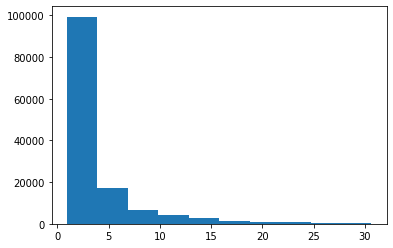

In [13]:
plt.hist(np.exp(np.array(trainD.weights / 20, dtype=float)))

In [18]:
import catboost

In [15]:
train_pool = catboost.Pool(trainD.features, trainD.targets, cat_features=dataset.CAT_FEATURES_V4)
val_pool = catboost.Pool(valD.features, valD.targets, cat_features=dataset.CAT_FEATURES_V4)

In [16]:
from collections import Counter
Counter(val_pool.get_label())

Counter({4: 1229, 0: 204, 5: 1184, 1: 8389, 3: 1314, 2: 1212})

In [17]:
train_pool.shape, val_pool.shape

((133032, 7210), (13532, 7210))

In [50]:
model = catboost.CatBoostClassifier(n_estimators=10000)

In [ ]:
model.fit(train_pool, eval_set=val_pool)  # 0.305, 0.333, / 0.263, 0.388

Learning rate set to 0.049409
0:	learn: 1.6443997	test: 1.6644641	best: 1.6644641 (0)	total: 5.25s	remaining: 14h 35m 5s
1:	learn: 1.5233408	test: 1.5561686	best: 1.5561686 (1)	total: 8.69s	remaining: 12h 4m 1s
2:	learn: 1.4223686	test: 1.4637431	best: 1.4637431 (2)	total: 13.3s	remaining: 12h 17m 35s
3:	learn: 1.3406777	test: 1.3911112	best: 1.3911112 (3)	total: 18.2s	remaining: 12h 38m 29s
4:	learn: 1.2690960	test: 1.3246399	best: 1.3246399 (4)	total: 22.9s	remaining: 12h 42m 15s
5:	learn: 1.2084502	test: 1.2702006	best: 1.2702006 (5)	total: 27s	remaining: 12h 28m 17s
6:	learn: 1.1544328	test: 1.2206764	best: 1.2206764 (6)	total: 30.9s	remaining: 12h 15m 54s
7:	learn: 1.1050319	test: 1.1745043	best: 1.1745043 (7)	total: 35.9s	remaining: 12h 28m 13s
8:	learn: 1.0627533	test: 1.1357289	best: 1.1357289 (8)	total: 41.4s	remaining: 12h 46m 9s
9:	learn: 1.0246271	test: 1.1008629	best: 1.1008629 (9)	total: 45.6s	remaining: 12h 39m 36s
10:	learn: 0.9894043	test: 1.0682665	best: 1.0682665 (10

In [ ]:
model.get_all_params()

In [ ]:
model.predict_proba(trainD.features[0].reshape(1,-1))

In [ ]:
model.classes_

In [ ]:
model.save_model("../submissions/simple/models/v9.cbm")

In [47]:
model.feature_importances_[:100]

array([3.88155442e+00, 5.23721429e-01, 1.53315736e+00, 1.80684075e+01,
       1.42098814e+01, 6.40749546e-01, 8.60292955e-01, 4.29625206e+00,
       4.92371983e+00, 5.47901807e-01, 5.58933665e-01, 3.98338737e-01,
       2.96479427e-01, 2.69626673e-01, 1.35330458e-01, 8.91609371e-01,
       2.01598627e-01, 2.84045664e-01, 1.68363909e-01, 3.38436744e-02,
       1.67969243e-01, 1.19950604e-01, 8.29330690e-05, 3.95940466e+00,
       2.81753226e+01, 1.42539636e+00, 1.85117179e+00, 4.00109426e-01,
       2.71870377e-01, 9.63834925e-02, 9.47759236e-02, 3.74476796e-01,
       1.40735395e+00, 2.85777123e+00, 0.00000000e+00, 0.00000000e+00,
       2.16401402e-01, 2.73528663e-01, 0.00000000e+00, 0.00000000e+00,
       4.95478203e-02, 0.00000000e+00, 1.74187326e-03, 1.56919672e-02,
       0.00000000e+00, 0.00000000e+00, 1.32037936e-02, 4.90370732e-02,
       7.91212650e-04, 1.45938583e-03, 1.05824667e-02, 2.84092535e-02,
       0.00000000e+00, 1.47723982e-02, 4.49167545e-03, 2.90063799e-03,
      

In [116]:
catboost.CatBoostClassifier().load_model("../submissions/simple/models/v1.cbm").classes_

array([0, 1, 2, 3, 4, 5])